# Tutorial 4: continuous convolutional filter

In this tutorial we will show how to use the Continouous Convolutional Filter, and how to build common Deep Learning architectures with it. The implementation of the filter follows the original work [**A Continuous Convolutional Trainable Filter for Modelling Unstructured Data**](https://arxiv.org/abs/2210.13416) of Coscia Dario, Laura Meneghetti, Nicola Demo, Giovanni Stabile, and Gianluigi Rozza.

First of all we import the modules needed for the tutorial, which include:

* `ContinuousConv` class from `pina.model.layers` which implements the continuous convolutional filter
* `PyTorch` and `Matplotlib` for tensorial operations and visualization respectively

In [1]:
import torch 
import matplotlib.pyplot as plt 
from pina.model.layers import ContinuousConvBlock 
import torchvision # for MNIST dataset
from pina.model import FeedForward # for building AE and MNIST classification

The tutorial is structured as follow: 
* [Continuous filter background](#continuous-filter-background): understand how the convolutional filter works and how to use it.
* [Building a MNIST Classifier](#building-a-mnist-classifier): show how to build a simple classifier using the MNIST dataset and how to combine a continuous convolutional layer with a feedforward neural network. 
* [Building a Continuous Convolutional Autoencoder](#building-a-continuous-convolutional-autoencoder): show how to use the continuous filter to work with unstructured data for autoencoding and up-sampling.

## Continuous filter background

As reported by the authors in the original paper: in contrast to discrete convolution, continuous convolution is mathematically defined as:

$$
    \mathcal{I}_{\rm{out}}(\mathbf{x}) = \int_{\mathcal{X}}  \mathcal{I}(\mathbf{x} + \mathbf{\tau}) \cdot \mathcal{K}(\mathbf{\tau}) d\mathbf{\tau},
$$
where $\mathcal{K} : \mathcal{X}  \rightarrow \mathbb{R}$ is the *continuous filter* function, and $\mathcal{I} : \Omega \subset \mathbb{R}^N \rightarrow \mathbb{R}$ is the input function. The continuous filter function is approximated using a FeedForward Neural Network, thus trainable during the training phase. The way in which the integral is approximated can be different, currently on **PINA** we approximate it using a simple sum, as suggested by the authors. Thus, given $\{\mathbf{x}_i\}_{i=1}^{n}$ points in $\mathbb{R}^N$ of the input function mapped on the $\mathcal{X}$ filter domain, we approximate the above equation as:
$$
    \mathcal{I}_{\rm{out}}(\mathbf{\tilde{x}}_i) = \sum_{{\mathbf{x}_i}\in\mathcal{X}}  \mathcal{I}(\mathbf{x}_i + \mathbf{\tau}) \cdot \mathcal{K}(\mathbf{x}_i),
$$
where $\mathbf{\tau} \in \mathcal{S}$, with $\mathcal{S}$ the set of available strides, corresponds to the current stride position of the filter, and $\mathbf{\tilde{x}}_i$ points are obtained by taking the centroid of the filter position mapped on the $\Omega$ domain. 

We will now try to pratically see how to work with the filter. From the above definition we see that what is needed is:
1. A domain and a function defined on that domain (the input)
2. A stride, corresponding to the positions where the filter needs to be $\rightarrow$ `stride` variable in `ContinuousConv`
3. The filter rectangular domain $\rightarrow$ `filter_dim` variable in `ContinuousConv`

### Input function

The input function for the continuous filter is defined as a tensor of shape: $$[B \times N_{in} \times N \times D]$$ where $B$ is the batch_size, $N_{in}$ is the number of input fields, $N$ the number of points in the mesh, $D$ the dimension of the problem. In particular:
* $D$ is the number of spatial variables + 1. The last column must contain the field value. For example for 2D problems $D=3$ and the tensor will be something like `[first coordinate, second coordinate, field value]`
* $N_{in}$ represents the number of vectorial function presented. For example a vectorial function $f = [f_1, f_2]$ will have $N_{in}=2$ 

Let's see an example to clear the ideas. We will be verbose to explain in details the input form. We wish to create the function:
$$
f(x, y) = [\sin(\pi x) \sin(\pi y), -\sin(\pi x) \sin(\pi y)] \quad (x,y)\in[0,1]\times[0,1]
$$

using a batch size of one.

In [3]:
# batch size fixed to 1
batch_size = 1

# points in the mesh fixed to 200
N = 200

# vectorial 2 dimensional function, number_input_fileds=2
number_input_fileds = 2

# 2 dimensional spatial variables, D = 2 + 1 = 3
D = 3

# create the function f domain as random 2d points in [0, 1]
domain = torch.rand(size=(batch_size, number_input_fileds, N, D-1))
print(f"Domain has shape: {domain.shape}")

# create the functions
pi = torch.acos(torch.tensor([-1.])) # pi value
f1 = torch.sin(pi * domain[:, 0, :, 0]) * torch.sin(pi * domain[:, 0, :, 1])
f2 = - torch.sin(pi * domain[:, 1, :, 0]) * torch.sin(pi * domain[:, 1, :, 1])

# stacking the input domain and field values
data = torch.empty(size=(batch_size, number_input_fileds, N, D))
data[..., :-1] = domain # copy the domain
data[:, 0, :, -1] = f1 # copy first field value
data[:, 1, :, -1] = f1  # copy second field value
print(f"Filter input data has shape: {data.shape}")

Domain has shape: torch.Size([1, 2, 200, 2])
Filter input data has shape: torch.Size([1, 2, 200, 3])


### Stride

The stride is passed as a dictionary `stride` which tells the filter where to go. Here is an example for the $[0,1]\times[0,5]$ domain:

```python
# stride definition
stride = {"domain": [1, 5],
          "start": [0, 0],
          "jump": [0.1, 0.3],
          "direction": [1, 1],
          }
```
This tells the filter:
1. `domain`: square domain (the only implemented) $[0,1]\times[0,5]$. The minimum value is always zero, while the maximum is specified by the user
2. `start`: start position of the filter, coordinate $(0, 0)$
3. `jump`: the jumps of the centroid of the filter to the next position $(0.1, 0.3)$
4. `direction`: the directions of the jump, with `1 = right`, `0 = no jump`,`-1 = left` with respect to the current position

**Note**

We are planning to release the possibility to directly pass a list of possible strides!

### Filter definition

Having defined all the previous blocks we are able to construct the continuous filter.

Suppose we would like to get an ouput with only one field, and let us fix the filter dimension to be $[0.1, 0.1]$.

In [4]:
# filter dim
filter_dim = [0.1, 0.1]

# stride
stride = {"domain": [1, 1],
          "start": [0, 0],
          "jump": [0.08, 0.08],
          "direction": [1, 1],
          }

# creating the filter         
cConv = ContinuousConvBlock(input_numb_field=number_input_fileds,
                        output_numb_field=1,
                        filter_dim=filter_dim,
                        stride=stride)

/Users/dariocoscia/anaconda3/envs/pina/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343673238/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


That's it! In just one line of code we have created the continuous convolutional filter. By default the `pina.model.FeedForward` neural network is intitialised, more on the [documentation](https://mathlab.github.io/PINA/_rst/fnn.html). In case the mesh doesn't change during training we can set the `optimize` flag equals to `True`, to exploit optimizations for finding the points to convolve.

In [5]:
# creating the filter + optimization
cConv = ContinuousConvBlock(input_numb_field=number_input_fileds,
                       output_numb_field=1,
                       filter_dim=filter_dim,
                       stride=stride,
                       optimize=True)


Let's try to do a forward pass

In [6]:
print(f"Filter input data has shape: {data.shape}")

#input to the filter
output = cConv(data)

print(f"Filter output data has shape: {output.shape}")

Filter input data has shape: torch.Size([1, 2, 200, 3])
Filter output data has shape: torch.Size([1, 1, 169, 3])


If we don't want to use the default `FeedForward` neural network, we can pass a specified torch model in the `model` keyword as follow: 


In [7]:
class SimpleKernel(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self. model = torch.nn.Sequential(
            torch.nn.Linear(2, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1))

    def forward(self, x):
        return self.model(x)


cConv = ContinuousConvBlock(input_numb_field=number_input_fileds,
                       output_numb_field=1,
                       filter_dim=filter_dim,
                       stride=stride,
                       optimize=True,
                       model=SimpleKernel)


Notice that we pass the class and not an already built object!

## Building a MNIST Classifier

Let's see how we can build a MNIST classifier using a continuous convolutional filter. We will use the MNIST dataset from PyTorch. In order to keep small training times we use only 6000 samples for training and 1000 samples for testing.

In [8]:
from torch.utils.data import DataLoader, SubsetRandomSampler

numb_training = 6000  # get just 6000 images for training
numb_testing= 1000  # get just 1000 images for training
seed = 111          # for reproducibility
batch_size = 8      # setting batch size

# setting the seed
torch.manual_seed(seed)

# downloading the dataset
train_data = torchvision.datasets.MNIST('./data/', train=True, download=True,
                                        transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                (0.1307,), (0.3081,))
                                        ]))
subsample_train_indices = torch.randperm(len(train_data))[:numb_training]
train_loader = DataLoader(train_data, batch_size=batch_size,
                          sampler=SubsetRandomSampler(subsample_train_indices))

test_data = torchvision.datasets.MNIST('./data/', train=False, download=True,
                                        transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                (0.1307,), (0.3081,))
                                        ]))
subsample_test_indices = torch.randperm(len(train_data))[:numb_testing]
test_loader = DataLoader(train_data, batch_size=batch_size,
                          sampler=SubsetRandomSampler(subsample_train_indices))

100%|██████████| 9912422/9912422 [00:00<00:00, 26842487.33it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 93758276.95it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21185082.59it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10560160.07it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Let's now build a simple classifier. The MNIST dataset is composed by vectors of shape `[batch, 1, 28, 28]`, but we can image them as one field functions where the pixels $ij$ are the coordinate $x=i, y=j$ in a $[0, 27]\times[0,27]$ domain, and the pixels value are the field values. We just need a function to transform the regular tensor in a tensor compatible for the continuous filter:

In [9]:
def transform_input(x):
    batch_size = x.shape[0]
    dim_grid = tuple(x.shape[:-3:-1])

    # creating the n dimensional mesh grid for a single channel image
    values_mesh = [torch.arange(0, dim).float() for dim in dim_grid]
    mesh = torch.meshgrid(values_mesh)
    coordinates_mesh = [x.reshape(-1, 1) for x in mesh]
    coordinates = torch.cat(coordinates_mesh, dim=1).unsqueeze(
        0).repeat((batch_size, 1, 1)).unsqueeze(1)

    return torch.cat((coordinates, x.flatten(2).unsqueeze(-1)), dim=-1)


# let's try it out
image, s = next(iter(train_loader))
print(f"Original MNIST image shape: {image.shape}")

image_transformed = transform_input(image)
print(f"Transformed MNIST image shape: {image_transformed.shape}")


Original MNIST image shape: torch.Size([8, 1, 28, 28])
Transformed MNIST image shape: torch.Size([8, 1, 784, 3])


We can now build a simple classifier! We will use just one convolutional filter followed by a feedforward neural network

In [11]:
# setting the seed
torch.manual_seed(seed)

class ContinuousClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # number of classes for classification
        numb_class = 10

        # convolutional block
        self.convolution = ContinuousConvBlock(input_numb_field=1,
                                          output_numb_field=4,
                                          stride={"domain": [27, 27],
                                                  "start": [0, 0],
                                                  "jumps": [4, 4],
                                                  "direction": [1, 1.],
                                                  },
                                          filter_dim=[4, 4],
                                          optimize=True)
        # feedforward net
        self.nn = FeedForward(input_dimensions=196,
                              output_dimensions=numb_class,
                              layers=[120, 64],
                              func=torch.nn.ReLU)

    def forward(self, x):
        # transform input + convolution
        x = transform_input(x)
        x = self.convolution(x)
        # feed forward classification
        return self.nn(x[..., -1].flatten(1))


net = ContinuousClassifier()

Let's try to train it using a simple pytorch training loop. We train for juts 1 epoch using Adam optimizer with a $0.001$ learning rate.

In [14]:
# setting the seed
torch.manual_seed(seed)

# optimizer and loss function
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    
            print(
                f'batch [{i + 1}/{numb_training//batch_size}] loss[{running_loss / 500:.3f}]')
            running_loss = 0.0


batch [50/750] loss[0.039]
batch [100/750] loss[0.031]
batch [150/750] loss[0.030]
batch [200/750] loss[0.028]
batch [250/750] loss[0.023]
batch [300/750] loss[0.026]
batch [350/750] loss[0.029]
batch [400/750] loss[0.031]
batch [450/750] loss[0.030]
batch [500/750] loss[0.023]
batch [550/750] loss[0.019]
batch [600/750] loss[0.025]
batch [650/750] loss[0.020]
batch [700/750] loss[0.028]
batch [750/750] loss[0.028]


Let's see the performance on the train set!

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    f'Accuracy of the network on the 1000 test images: {(correct / total):.3%}')


Accuracy of the network on the 1000 test images: 94.767%


As we can see we have very good performance for having traing only for 1 epoch! Nevertheless, we are still using structured data... Let's see how we can build an autoencoder for unstructured data now.

## Building a Continuous Convolutional Autoencoder

Just as toy problem, we will now build an autoencoder for the following function $f(x,y)=\sin(\pi x)\sin(\pi y)$ on the unit circle domain centered in $(0.5, 0.5)$. We will also see the ability to up-sample (once trained) the results without retraining. Let's first create the input and visualize it, we will use firstly a mesh of $100$ points.

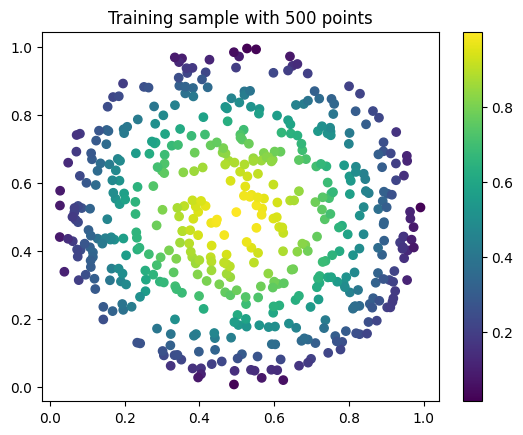

In [16]:
# create inputs
def circle_grid(N=100):
    """Generate points withing a unit 2D circle centered in (0.5, 0.5)

        :param N: number of points
        :type N: float
        :return: [x, y] array of points
        :rtype: torch.tensor
        """

    PI = torch.acos(torch.zeros(1)).item() * 2
    R = 0.5
    centerX = 0.5
    centerY = 0.5

    r = R * torch.sqrt(torch.rand(N))
    theta = torch.rand(N) * 2 * PI

    x = centerX + r * torch.cos(theta)
    y = centerY + r * torch.sin(theta)

    return torch.stack([x, y]).T

# create the grid
grid = circle_grid(500)

# create input
input_data = torch.empty(size=(1, 1, grid.shape[0], 3))
input_data[0, 0, :, :-1] = grid
input_data[0, 0, :, -1] = torch.sin(pi * grid[:, 0]) * torch.sin(pi * grid[:, 1])

# visualize data
plt.title("Training sample with 500 points")
plt.scatter(grid[:, 0], grid[:, 1], c=input_data[0, 0, :, -1])
plt.colorbar()
plt.show()


Let's now build a simple autoencoder using the continuous convolutional filter. The data is clearly unstructured and a simple convolutional filter might not work without projecting or interpolating first. Let's first build and `Encoder` and `Decoder` class, and then a `Autoencoder` class that contains both.

In [19]:
class Encoder(torch.nn.Module):
    def __init__(self, hidden_dimension):
        super().__init__()

        # convolutional block
        self.convolution = ContinuousConvBlock(input_numb_field=1,
                                          output_numb_field=2,
                                          stride={"domain": [1, 1],
                                                  "start": [0, 0],
                                                  "jumps": [0.05, 0.05],
                                                  "direction": [1, 1.],
                                                  },
                                          filter_dim=[0.15, 0.15],
                                          optimize=True)
        # feedforward net
        self.nn = FeedForward(input_dimensions=400,
                              output_dimensions=hidden_dimension,
                              layers=[240, 120])

    def forward(self, x):
        # convolution
        x = self.convolution(x)
        # feed forward pass
        return self.nn(x[..., -1])


class Decoder(torch.nn.Module):
    def __init__(self, hidden_dimension):
        super().__init__()

        # convolutional block
        self.convolution = ContinuousConvBlock(input_numb_field=2,
                                          output_numb_field=1,
                                          stride={"domain": [1, 1],
                                                  "start": [0, 0],
                                                  "jumps": [0.05, 0.05],
                                                  "direction": [1, 1.],
                                                  },
                                          filter_dim=[0.15, 0.15],
                                          optimize=True)
        # feedforward net
        self.nn = FeedForward(input_dimensions=hidden_dimension,
                              output_dimensions=400,
                              layers=[120, 240])

    def forward(self, weights, grid):
        # feed forward pass
        x = self.nn(weights)
        # transpose convolution
        return torch.sigmoid(self.convolution.transpose(x, grid))


Very good! Notice that in the `Decoder` class in the `forward` pass we have used the `.transpose()` method of the `ContinuousConvolution` class. This method accepts the `weights` for upsampling and the `grid` on where to upsample. Let's now build the autoencoder! We set the hidden dimension in the `hidden_dimension` variable. We apply the sigmoid on the output since the field value is between $[0, 1]$. 

In [20]:
class Autoencoder(torch.nn.Module):
    def __init__(self, hidden_dimension=10):
        super().__init__()

        self.encoder = Encoder(hidden_dimension)
        self.decoder = Decoder(hidden_dimension)

    def forward(self, x):
        # saving grid for later upsampling
        grid = x.clone().detach()
        # encoder
        weights = self.encoder(x)
        # decoder
        out = self.decoder(weights, grid)
        return out


net = Autoencoder()

Let's now train the autoencoder, minimizing the mean square error loss and optimizing using Adam.

In [21]:
# setting the seed
torch.manual_seed(seed)

# optimizer and loss function
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
max_epochs = 150

for epoch in range(max_epochs):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(input_data)
    loss = criterion(outputs[..., -1], input_data[..., -1])
    loss.backward()
    optimizer.step()

    # print statistics
    if epoch % 10 ==9:
        print(f'epoch [{epoch + 1}/{max_epochs}] loss [{loss.item():.2}]')


epoch [10/150] loss [0.0058]
epoch [20/150] loss [0.0031]
epoch [30/150] loss [0.0016]
epoch [40/150] loss [0.0013]
epoch [50/150] loss [0.001]
epoch [60/150] loss [0.00089]
epoch [70/150] loss [0.00078]
epoch [80/150] loss [0.00071]
epoch [90/150] loss [0.00066]
epoch [100/150] loss [0.00062]
epoch [110/150] loss [0.0006]
epoch [120/150] loss [0.00058]
epoch [130/150] loss [0.00056]
epoch [140/150] loss [0.00055]
epoch [150/150] loss [0.00054]


Let's visualize the two solutions side by side!

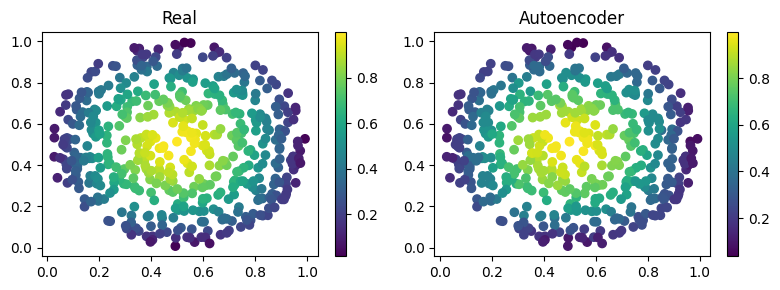

In [22]:
net.eval()

# get output and detach from computational graph for plotting
output = net(input_data).detach()

# visualize data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
pic1 = axes[0].scatter(grid[:, 0], grid[:, 1], c=input_data[0, 0, :, -1])
axes[0].set_title("Real")
fig.colorbar(pic1)
plt.subplot(1, 2, 2)
pic2 = axes[1].scatter(grid[:, 0], grid[:, 1], c=output[0, 0, :, -1])
axes[1].set_title("Autoencoder")
fig.colorbar(pic2)
plt.tight_layout()
plt.show()


As we can see the two are really similar! We can compute the $l_2$ error quite easily as well:

In [23]:
def l2_error(input_, target):
    return torch.linalg.norm(input_-target, ord=2)/torch.linalg.norm(input_, ord=2)


print(f'l2 error: {l2_error(input_data[0, 0, :, -1], output[0, 0, :, -1]):.2%}')

l2 error: 4.09%


More or less $4\%$ in $l_2$ error, which is really low considering the fact that we use just **one** convolutional layer and a simple feedforward to decrease the dimension. Let's see now some peculiarity of the filter.

### Filter for upsampling

Suppose we have already the hidden dimension and we want to upsample on a differen grid with more points. Let's see how to do it:

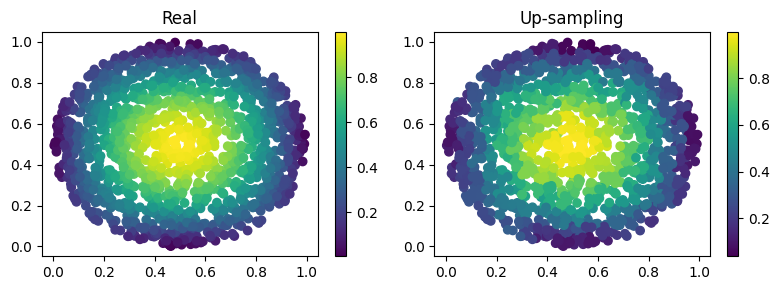

In [24]:
# setting the seed
torch.manual_seed(seed)

grid2 = circle_grid(1500) # triple number of points
input_data2 = torch.zeros(size=(1, 1, grid2.shape[0], 3))
input_data2[0, 0, :, :-1] = grid2
input_data2[0, 0, :, -1] = torch.sin(pi *
                                    grid2[:, 0]) * torch.sin(pi * grid2[:, 1])

# get the hidden dimension representation from original input
latent = net.encoder(input_data)

# upsample on the second input_data2
output = net.decoder(latent, input_data2).detach()

# show the picture
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
pic1 = axes[0].scatter(grid2[:, 0], grid2[:, 1], c=input_data2[0, 0, :, -1])
axes[0].set_title("Real")
fig.colorbar(pic1)
plt.subplot(1, 2, 2)
pic2 = axes[1].scatter(grid2[:, 0], grid2[:, 1], c=output[0, 0, :, -1])
axes[1].set_title("Up-sampling")
fig.colorbar(pic2)
plt.tight_layout()
plt.show()


As we can see we have a very good approximation of the original function, even thought some noise is present. Let's calculate the error now:

In [25]:
print(f'l2 error: {l2_error(input_data2[0, 0, :, -1], output[0, 0, :, -1]):.2%}')

l2 error: 8.41%


### Autoencoding at different resolution
In the previous example we already had the hidden dimension (of original input) and we used it to upsample. Sometimes however we have a more fine mesh solution and we simply want to encode it. This can be done without retraining! This procedure can be useful in case we have many points in the mesh and just a smaller part of them are needed for training. Let's see the results of this:

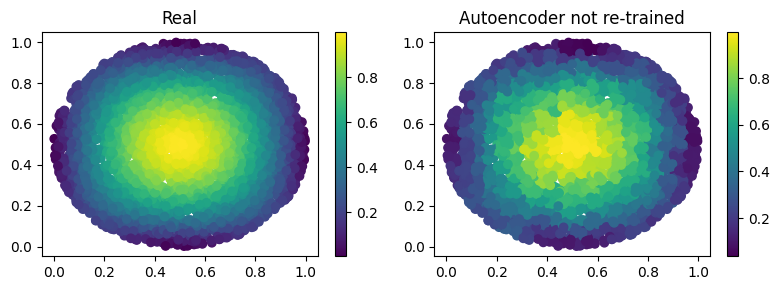

l2 error: 8.63%


In [26]:
# setting the seed
torch.manual_seed(seed)

grid2 = circle_grid(3500)  # very fine mesh
input_data2 = torch.zeros(size=(1, 1, grid2.shape[0], 3))
input_data2[0, 0, :, :-1] = grid2
input_data2[0, 0, :, -1] = torch.sin(pi *
                                     grid2[:, 0]) * torch.sin(pi * grid2[:, 1])

# get the hidden dimension representation from more fine mesh input
latent = net.encoder(input_data2)

# upsample on the second input_data2
output = net.decoder(latent, input_data2).detach()

# show the picture
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
pic1 = axes[0].scatter(grid2[:, 0], grid2[:, 1], c=input_data2[0, 0, :, -1])
axes[0].set_title("Real")
fig.colorbar(pic1)
plt.subplot(1, 2, 2)
pic2 = axes[1].scatter(grid2[:, 0], grid2[:, 1], c=output[0, 0, :, -1])
axes[1].set_title("Autoencoder not re-trained")
fig.colorbar(pic2)
plt.tight_layout()
plt.show()

# calculate l2 error
print(
    f'l2 error: {l2_error(input_data2[0, 0, :, -1], output[0, 0, :, -1]):.2%}')


## What's next?

We have shown the basic usage of a convolutional filter. In the next tutorials we will show how to combine the PINA framework with the convolutional filter to train in few lines and efficiently a Neural Network!